In [ ]:
from tensorflow import keras
from keras.layers import Input
import os
from google.colab import drive
import random as rn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

drive.mount('/content/drive/')

out_path = '/content/drive/My Drive/Ritorti[_Pasco]/project/numpy_data' 


Mounted at /content/drive/


# **Dataset load**

In [ ]:

def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

def load_testing():
  images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  return images,labels

train_images, train_labels = load_training()



test_images, test_labels = load_testing()

# **Preprocessing**

##Preparing training and test set for mass-calcification classification





In [ ]:
#MASS-CALCIFICATION
train_zipped = zip(train_images,train_labels)
test_zipped = zip(test_images,test_labels)
train_images_mass_calc,train_labels_mass_calc = [],[]
test_images_mass_calc,test_labels_mass_calc = [],[]
train_images_baseline,test_images_baseline = [],[]

#training
for im,la in train_zipped:
  if la == 1 or la == 2: #masses -> 0
    train_images_mass_calc.append(im)
    train_labels_mass_calc.append(0)
  elif la == 3 or la == 4: #calcification -> 1
    train_images_mass_calc.append(im)
    train_labels_mass_calc.append(1)

#testing
for im,la in test_zipped:
  if la == 1 or la == 2: #masses -> 0
    test_images_mass_calc.append(im)
    test_labels_mass_calc.append(0)
  elif la == 3 or la == 4: #calcification -> 1
    test_images_mass_calc.append(im)
    test_labels_mass_calc.append(1)

train_images_baseline = [train_images[2*i] for i in range(len(train_images)//2)]
test_images_baseline = [test_images[2*i] for i in range(len(test_images)//2)]

train_images_mass_calc = np.array(train_images_mass_calc)
train_labels_mass_calc = np.array(train_labels_mass_calc)
test_images_mass_calc = np.array(test_images_mass_calc)
test_labels_mass_calc = np.array(test_labels_mass_calc)
train_images_baseline = np.array(train_images_baseline)
test_images_baseline = np.array(test_images_baseline)
print(f"Shape training: {train_images_mass_calc.shape}")
print(f"Training: {train_images_mass_calc.astype}")
print(f"Shape testing: {test_images_mass_calc.shape}")
print(f"Shape training baseline: {train_images_baseline.shape}")
print(f"Shape testing baseline: {test_images_baseline.shape}")

Shape training: (2676, 150, 150)
Training: <built-in method astype of numpy.ndarray object at 0x7f5648bba080>
Shape testing: (336, 150, 150)
Shape training baseline: (2676, 150, 150)
Shape testing baseline: (336, 150, 150)


In [ ]:
# Setting of parameters for reproducible results
os.environ["PYTHONHASHSEED"]="0"
np.random.seed(31)
rn.seed(14)
tf.random.set_seed(1234)

## Some of our dataset view

Distribution of classes

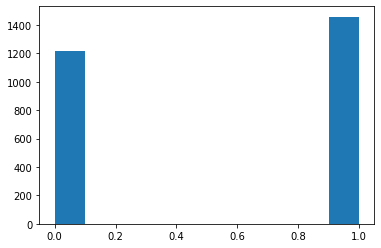

In [ ]:
plt.hist(train_labels_mass_calc)
plt.show()

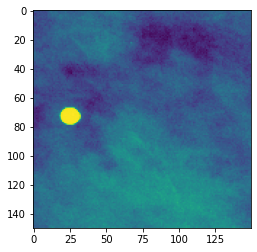

In [ ]:
plt.imshow(train_images_baseline[0,:,:])

uint16


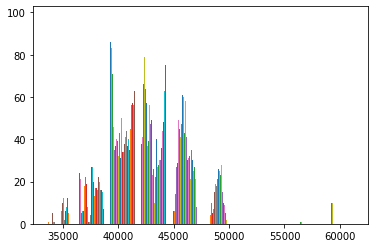

In [ ]:
print(train_images_baseline[0].dtype) # check the type
plt.hist(train_images_baseline[0]) # check the value range and the distribution
plt.show()

##Normalize training and testing



In [ ]:
train_images_baseline = train_images_baseline.reshape((2676, 150,150,1))
train_images_mass_calc = train_images_mass_calc.reshape((2676, 150,150,1))
test_images_baseline = test_images_baseline.reshape((336, 150,150,1))
test_images_mass_calc = test_images_mass_calc.reshape((336, 150,150,1))

train_images_baseline  = train_images_baseline .astype('float32') / 65535
train_images_mass_calc  = train_images_mass_calc .astype('float32') / 65535
test_images_baseline = test_images_baseline.astype('float32') / 65535
test_images_mass_calc = test_images_mass_calc.astype('float32') / 65535

##Build of the training augumentation and validation set 

In [ ]:
def generator_multiple_inputs(train_abnorm_images, train_base_images, train_labels,b_size):
    train_datagen = ImageDataGenerator(
        rotation_range=25,
        shear_range=0.6,
        zoom_range=1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    
    gen_abnormal = train_datagen.flow(train_abnorm_images, train_labels, batch_size=b_size)
    gen_baseline = train_datagen.flow(train_base_images, train_labels, batch_size=b_size)
    
    while True:
        X1i = gen_abnormal.next()
        X2i = gen_baseline.next()
        yield [X1i[0], X2i[0]], X1i[1]

# Shuffle the data
seed = 123
rng = np.random.RandomState(seed)
rng.shuffle(train_images_mass_calc)
rng = np.random.RandomState(seed)
rng.shuffle(train_images_baseline)
rng = np.random.RandomState(seed)
rng.shuffle(train_labels_mass_calc)

validation_split = 0.2

num_validation_samples = int(validation_split * len(train_images_mass_calc))
val_images_mass = train_images_mass_calc[-num_validation_samples:]
train_images_mass = train_images_mass_calc[:-num_validation_samples]
val_labels = train_labels_mass_calc[-num_validation_samples:]
train_labels = train_labels_mass_calc[:-num_validation_samples]

val_images_base = train_images_baseline[-num_validation_samples:]
train_images_base = train_images_baseline[:-num_validation_samples]

train_generator = generator_multiple_inputs(train_images_mass, train_images_base,train_labels,64)
valid_generator = generator_multiple_inputs(val_images_mass, val_images_base,val_labels,64)

train_len = len(train_images_mass)
val_len = len(val_images_mass)

# **Siamese network**

In [ ]:
#SMALL CONVNET WITH CONV2D AND MAXPOOLING2D
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras import backend as K
from keras.models import Model, Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64

l_input = Input((150,150,1))
r_input = Input((150,150,1))


CNN = models.Sequential()
CNN.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D((2, 2)))
CNN.add(layers.Flatten())

baseline_model = CNN(l_input)
abnorm_model = CNN(r_input)

L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))
L1_distance = L1_layer([baseline_model, abnorm_model])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[l_input,r_input],outputs=prediction)
optimizer = Adam(0.001, decay=2.5e-4)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])
history = siamese_net.fit(
    train_generator,
    steps_per_epoch=train_len//BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=val_len//BATCH_SIZE,
    epochs= 30)

Epoch 1/30
33/33 [==============================] - 9s 273ms/step - loss: 0.6930 - accuracy: 0.5331 - val_loss: 0.6917 - val_accuracy: 0.5469
Epoch 2/30
33/33 [==============================] - 9s 269ms/step - loss: 0.6912 - accuracy: 0.5305 - val_loss: 0.6867 - val_accuracy: 0.5508
Epoch 3/30
33/33 [==============================] - 9s 269ms/step - loss: 0.6892 - accuracy: 0.5455 - val_loss: 0.6983 - val_accuracy: 0.4844
Epoch 4/30
33/33 [==============================] - 9s 265ms/step - loss: 0.6943 - accuracy: 0.5266 - val_loss: 0.6871 - val_accuracy: 0.5508
Epoch 5/30
33/33 [==============================] - 9s 268ms/step - loss: 0.6872 - accuracy: 0.5404 - val_loss: 0.6848 - val_accuracy: 0.5781
Epoch 6/30
33/33 [==============================] - 9s 269ms/step - loss: 0.6873 - accuracy: 0.5419 - val_loss: 0.6871 - val_accuracy: 0.5664
Epoch 7/30
33/33 [==============================] - 9s 270ms/step - loss: 0.6885 - accuracy: 0.5429 - val_loss: 0.6873 - val_accuracy: 0.5977
Epoch 

Save the model

In [ ]:
#dir_name ="/content/drive/My Drive/Ritorti[_Pasco]/models"
#if not os.path.exists(dir_name):
#  os.makedirs(dir_name)
#siamese_net.save(os.path.join(dir_name,'siamese_baseline.h5'))


# **Training and validation accuracy-loss diagrams**

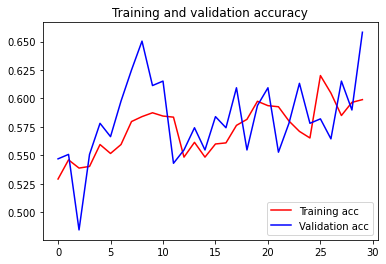

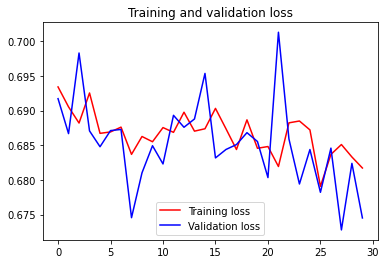

In [ ]:
import matplotlib.pyplot as plt

acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'r', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_1, 'r', label='Training loss')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Evaluating the model with the test set**

In [ ]:
test_loss, test_acc = siamese_net.evaluate([test_images_baseline,test_images_mass_calc],test_labels_mass_calc)
print('test_acc:', test_acc)

11/11 [==============================] - 0s 17ms/step - loss: 0.6826 - accuracy: 0.6101
test_acc: 0.6101190447807312


In [ ]:
predictions = siamese_net.predict([test_images_baseline,test_images_mass_calc]) # get the output for each sample
predictions = np.round(predictions)
predictions = predictions.astype(int)
unique, counts = np.unique(test_labels_mass_calc, return_counts=True)
print('true',dict(zip(unique, counts)))
unique, counts = np.unique(predictions, return_counts=True)
print('pred',dict(zip(unique, counts)))

true {0: 179, 1: 157}
pred {0: 108, 1: 228}


**We save the predictions in a txt file to use them in the ensable method**


In [ ]:
#import csv
#dir_data_store ="/content/drive/My Drive/Ritorti[_Pasco]/data_store"
#if not os.path.exists(dir_data_store):
#  os.makedirs(dir_data_store)

#np.savetxt(os.path.join(dir_data_store,"predictions_siamese.csv"), predictions, delimiter=",")

**Evaluation of the model with the following tools:**


1.   Confusion matrix
2.   Accuracy, precision, recall and f1-score
3.   ROC curve

In [ ]:
from sklearn import metrics
metrics.confusion_matrix(test_labels_mass_calc,predictions)

array([[ 78, 101],
       [ 30, 127]])

In [ ]:
# accuracy: (TP+TN)/(TP+FP+FN+TN): percentage of correctly predicted samples
metrics.accuracy_score(test_labels_mass_calc,predictions)

0.6101190476190477

In [ ]:
# precision: TP/(TP+FP): The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
metrics.precision_score(test_labels_mass_calc,predictions)

0.5570175438596491

In [ ]:
# recall: TP/(TP+FN): The recall is intuitively the ability of the classifier to find all the positive samples.
metrics.recall_score(test_labels_mass_calc,predictions)

0.8089171974522293

In [ ]:
# f1-score: 2*(precision*recall)/(precision + recall). The F1-score is the harmonic mean of precision and sensitivity
metrics.f1_score(test_labels_mass_calc,predictions)

0.6597402597402598

In [ ]:
# classification report: Build a text report showing the main classification metrics
print(metrics.classification_report(test_labels_mass_calc,predictions))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       179
           1       0.66      0.66      0.66       157

    accuracy                           0.68       336
   macro avg       0.68      0.68      0.68       336
weighted avg       0.68      0.68      0.68       336



In [ ]:
fpr,tpr,th = metrics.roc_curve(test_labels_mass_calc,predictions)
roc_auc = metrics.roc_auc_score(test_labels_mass_calc,predictions)

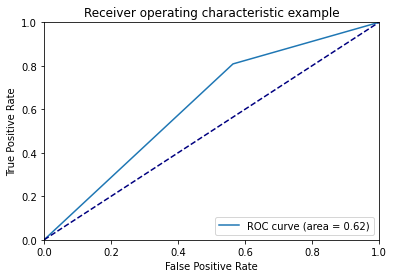

In [ ]:
#from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig(os.path.join(dir_img,"ROC_curve.png"))
plt.show()